In [4]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

project_root = Path('..').resolve()
print('Project root:', project_root)

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from uais.supervised.train_fraud_supervised import FraudModelConfig, train_fraud_model
from uais.utils.metrics import compute_classification_metrics
from uais.utils.plotting import plot_roc_curve, plot_pr_curve


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [5]:
from uais.data.load_fraud_data import load_fraud_data
from uais.features.fraud_features import build_fraud_feature_table
from sklearn.ensemble import HistGradientBoostingClassifier

# Use creditcard dataset explicitly to avoid mixing schemas
fraud_path = project_root / 'data' / 'raw' / 'fraud' / 'creditcard.csv'
df_raw_fraud = load_fraud_data(fraud_path)
df_feats_fraud = build_fraud_feature_table(df_raw_fraud, 'Time', 'Amount', 'Class')

# Drop rows with missing target
df_feats_fraud = df_feats_fraud.dropna(subset=['Class']).copy()
df_feats_fraud['Class'] = df_feats_fraud['Class'].astype(int)

X_fraud = df_feats_fraud.drop(columns=['Class'])
y_fraud = df_feats_fraud['Class']

Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42
)

fraud_model = HistGradientBoostingClassifier(max_depth=4, learning_rate=0.1, max_iter=200, random_state=42)
fraud_model.fit(Xf_train, yf_train)
pf_test = fraud_model.predict_proba(Xf_test)[:, 1]


In [6]:
cyber_path = project_root / 'data' / 'processed' / 'cyber' / 'unsw_nb15_features.parquet'
df_cyber = pd.read_parquet(cyber_path)

X_cyber = df_cyber.drop(columns=['label'])
y_cyber = df_cyber['label'].astype(int)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cyber, y_cyber, test_size=0.2, stratify=y_cyber, random_state=42
)

cyber_model = HistGradientBoostingClassifier(max_depth=6, learning_rate=0.1, max_iter=200, random_state=42)
cyber_model.fit(Xc_train, yc_train)
pc_test = cyber_model.predict_proba(Xc_test)[:, 1]


Fusion meta-model metrics (toy example):
roc_auc: 0.7815
pr_auc: 0.5979
f1: 0.0233
precision: 1.0000
recall: 0.0118
accuracy: 0.8156


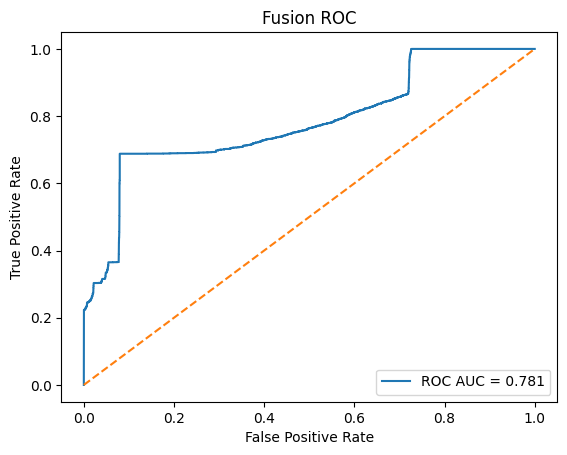

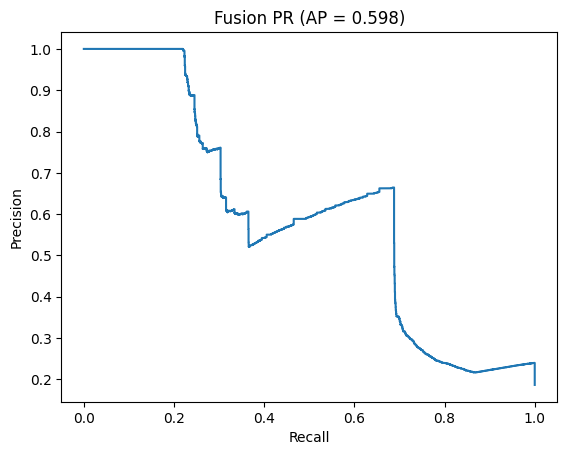

In [7]:
n = min(len(pf_test), len(pc_test))
fusion_features = np.stack([
    np.pad(pf_test[:n], (0, 0)),
    np.pad(pc_test[:n], (0, 0))
], axis=1)

y_fusion = ((pf_test[:n] > np.quantile(pf_test, 0.9)) |
            (pc_test[:n] > np.quantile(pc_test, 0.9))).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    fusion_features, y_fusion, test_size=0.3, stratify=y_fusion, random_state=42
)

meta_model = LogisticRegression()
meta_model.fit(X_train, y_train)
y_prob = meta_model.predict_proba(X_test)[:, 1]

fusion_metrics = compute_classification_metrics(y_test, y_prob, threshold=0.5)
print('Fusion meta-model metrics (toy example):')
for k, v in fusion_metrics.items():
    print(f"{k}: {v:.4f}")

plot_roc_curve(y_test, y_prob, title='Fusion ROC')
plot_pr_curve(y_test, y_prob, title='Fusion PR')
